In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
import ROOT
from numpy.random import normal
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [ ]:
# Coincidence table
# 0000 ---  ---  ---  ---  ---  ---  ---  --- 
# 1000 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0100 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0010 OOO  AOO  ---  ---  ---  ---  ---  ---
# 0001 OOO  AOO  ---  ---  ---  ---  ---  --- 
# 1100 OOO  AOO  OAO  ---  AAO  ---  ---  --- 
# 1010 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 1001 OOO  AOO  OAO  OOA  ---  ---  ---  --- 
# 0110 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0101 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0011 OOO  AOO  OAO  ---  AAO  ---  ---  ---
# 1110 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1101 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1011 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 0111 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 1111 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA 

In [2]:
dir1118_on = ['/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-18/2022-11-18_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma_overnight/']

In [9]:
ds1118_on = []
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain_bot = [556.997, 503.579, 549.769, 558.519]
for i,dir in enumerate(dir1118_on):
    for j in [0,9]:
        data = ds.Dataset('', pol=-1, channels=range(4), spe=gain_bot)
        for ch in range(4):
            subdir = '{}{}/'.format(dir, j)
            print(subdir)
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            print('nevents={}'.format(data.ch[ch].nevents))
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].clear()
        data.get_summed_integral_pe()
        ds1118_on.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-18/2022-11-18_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma_overnight/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-18/2022-11-18_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma_overnight/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-18/2022-11-18_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma_overnight/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-18/2022-11-18_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma_overnight/0/
nevents=50000
ch 0 nevents 50000 charge entries 50000
(50000,)
()
ch 1 nevents 50000 charge entries 50000
(50000,)
()
ch 2 nevents 50000 charge entries 50000
(50000,)
()
ch 3 nevents 50000 charge entries 50000
(50000,)
()
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-18/2022-11-18_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma_overnight/9/
nevent

(-50.0, 2000.0)

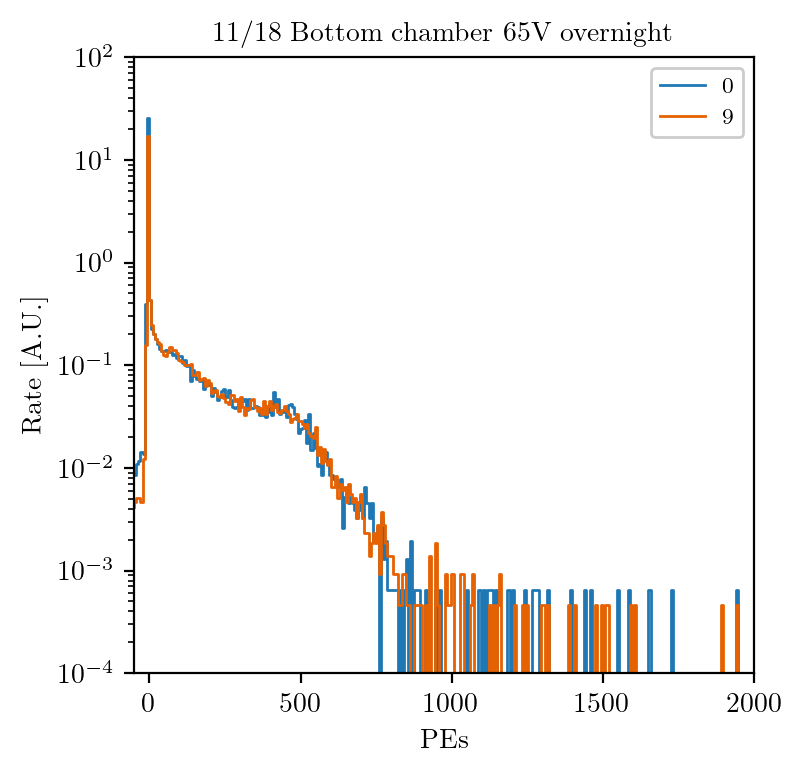

In [15]:
xmin = -50
xmax = 2000
nbins = 300
bin_width = (xmax-xmin)/nbins

hist = []
hist_bins = []
plt.figure(0,figsize=(4,4))
for i,dset in enumerate(ds1118_on):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
    h = h/np.sum(h[int((400-xmin)/bin_width):])
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label='{}'.format(i*9), linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/18 Bottom chamber 65V overnight')
plt.xlim(xmin, xmax)

# List of Datasets
- Top 11/17:
    * 000, 100, 001, 110, 011

In [2]:
dir1117 = [ '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_100_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_110_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_scintillation_coinc_111_cond_gamma_high_stat/']
coinc = ['OOO', 'AOO', 'OOA', 'AAO', 'OAA', 'AAA']

In [3]:
ds1117 = []
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[556.758,548.693,548.862,541.270], [556.997, 503.579, 549.769, 558.519]]
for i,dir in enumerate(dir1117):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=gain[0])
    for j in range(20):
        for ch in range(4):
            subdir = '{}{}/'.format(dir, j)
            print(subdir)
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            print('nevents={}'.format(data.ch[ch].nevents))
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    ds1117.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/1/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/1/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000

nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/14/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/14/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/14/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/14/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/15/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/15/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_sci

nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_100_cond_gamma/7/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_100_cond_gamma/8/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_100_cond_gamma/8/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_100_cond_gamma/8/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_100_cond_gamma/8/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_100_cond_gamma/9/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintilla

nevents=10043
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/1/
nevents=10043
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/1/
nevents=10043
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/2/
nevents=10087
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/2/
nevents=10087
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/2/
nevents=10087
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/2/
nevents=10087
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintilla

nevents=10691
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/15/
nevents=10691
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/15/
nevents=10691
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/16/
nevents=11127
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/16/
nevents=11127
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/16/
nevents=11127
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_001_cond_gamma/16/
nevents=11127
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_sci

nevents=11156
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_110_cond_gamma/9/
nevents=11156
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_110_cond_gamma/9/
nevents=11156
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_110_cond_gamma/9/
nevents=11156
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_110_cond_gamma/10/
nevents=11039
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_110_cond_gamma/10/
nevents=11039
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_110_cond_gamma/10/
nevents=11039
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scinti

nevents=10733
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/3/
nevents=10768
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/3/
nevents=10768
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/3/
nevents=10768
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/3/
nevents=10768
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/4/
nevents=10822
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/4/
nevents=10822
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintilla

nevents=10678
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/17/
nevents=10644
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/17/
nevents=10644
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/17/
nevents=10644
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/17/
nevents=10644
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/18/
nevents=10723
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_011_cond_gamma/18/
nevents=10723
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_sci

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_scintillation_coinc_111_cond_gamma_high_stat/10/
nevents=5003
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_scintillation_coinc_111_cond_gamma_high_stat/10/
nevents=5003
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_scintillation_coinc_111_cond_gamma_high_stat/10/
nevents=5003
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_scintillation_coinc_111_cond_gamma_high_stat/10/
nevents=5003
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_scintillation_coinc_111_cond_gamma_high_stat/11/
nevents=5004
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_scintillation_coinc_111_cond_gamma_high_stat/11/
nevents=5004
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11

174324 events simulated


(0.0, 300.0)

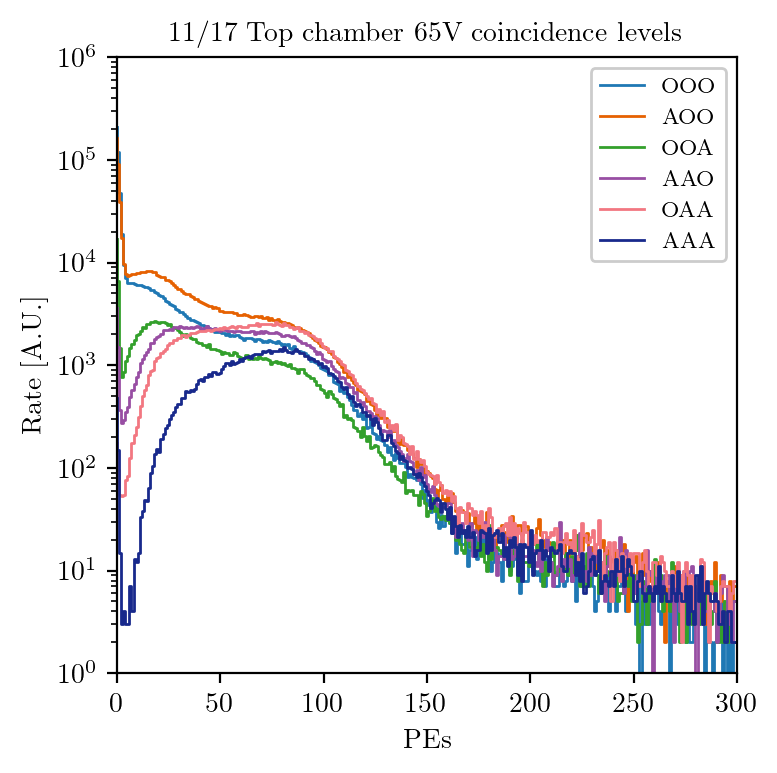

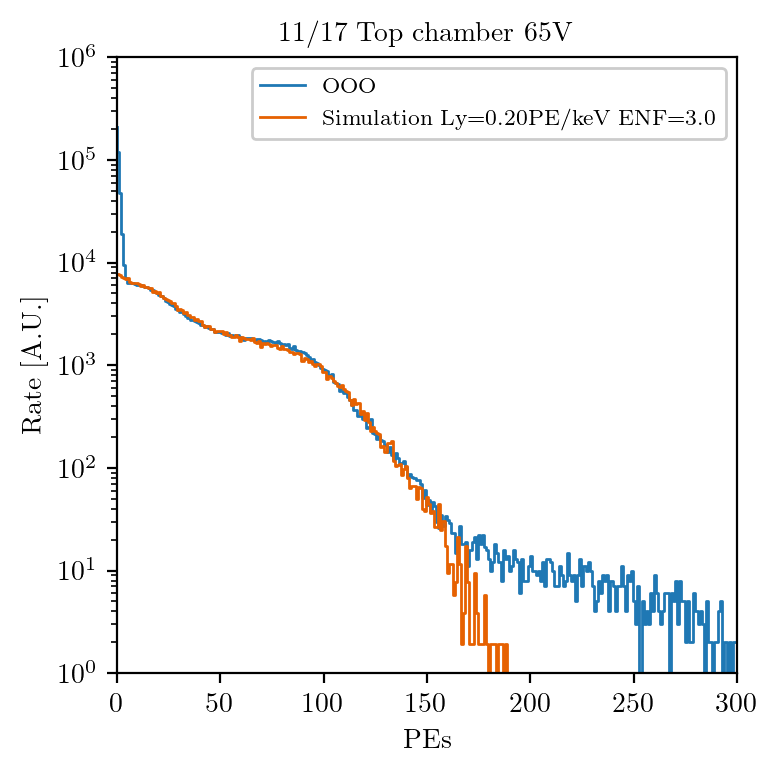

In [7]:
xmin = 0
xmax = 300
nbins = 300
bin_width = (xmax-xmin)/nbins

hist = []
hist_bins = []
plt.figure(0,figsize=(4,4))
for i,dset in enumerate(ds1117):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
#     h = h/np.sum(h[int((200-xmin)/bin_width):])
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label=coinc[i], linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Top chamber 65V coincidence levels')
plt.xlim(xmin, xmax)

plt.figure(1,figsize=(4,4))
# For the top
import ROOT
from numpy.random import normal
ly = 0.195
enf = 3.0
file = ROOT.TFile("~/sipm-analysis/jupyter/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")
simulated_pe = []
nev = 0
for i,ev in enumerate(tr):
    for j in range(1):
        simulated_pe.append(normal(ly*tr.Edep, np.sqrt(enf*ly*tr.Edep)))
        nev += 1
print('{} events simulated'.format(nev))
i = 0 #['OOO', 'AOO', 'OOA', 'AAO', 'OAA', 'AAA']
hSimPE, hSimPE_bins = np.histogram(simulated_pe, bins=np.linspace(xmin,xmax,nbins))
hSimPE = hSimPE*np.sum(hist[0][int((20-xmin)/bin_width):int((150-xmin)/bin_width)])/np.sum(hSimPE[int((20-xmin)/bin_width):int((150-xmin)/bin_width)])
plt.step(hist_bins[i][:-1], hist[i], label=coinc[i], linewidth=1)
plt.step(hSimPE_bins[:-1], hSimPE, label='Simulation Ly={:.2f}PE/keV ENF={:.1f}'.format(ly, enf), linewidth=1)
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Top chamber 65V')
plt.xlim(xmin, xmax)

# Fitting Attempt

In [20]:
def chisquare_two_hist(light_yield, enf, data_hist, data_hist_bins, data_hist_err, sim_tree, fit_range_in_pe):
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)
    bin_width = (xmax-xmin)/nbins
#     print(np.shape(data_hist), np.shape(data_hist_bins), np.shape(data_hist_err))
    
    simulated_pe = []
    for i,ev in enumerate(sim_tree):
        simulated_pe.append(normal(light_yield*sim_tree.Edep, np.sqrt(enf*light_yield*tr.Edep)))
    hSimPE, hSimPE_bins = np.histogram(simulated_pe, bins=np.linspace(xmin,xmax,nbins))
    hSimPE_err = np.sqrt(hSimPE)
#     print(np.shape(hSimPE), np.shape(hSimPE_bins), np.shape(hSimPE_err))
    simulated_pe = []
    fit_range_in_bin = [int((fit_range_in_pe[0]-xmin)/bin_width), int((fit_range_in_pe[1]-xmin)/bin_width)]
    norm_data = np.sum(data_hist[fit_range_in_bin[0]:fit_range_in_bin[1]])
    data_hist = data_hist/norm_data
    data_hist_err = data_hist_err/norm_data
    norm_sim = np.sum(hSimPE[fit_range_in_bin[0]:fit_range_in_bin[1]])
    hSimPE = hSimPE/norm_sim
    hSimPE_err = hSimPE_err/norm_sim
    chi_square = 0
    for i in range(fit_range_in_bin[0], fit_range_in_bin[1]):
        chi_square += (data_hist[i] - hSimPE[i])**2/((data_hist_err[i])**2 + (hSimPE_err[i])**2)
    dof = fit_range_in_pe[1]-fit_range_in_pe[0] - 3
    print(light_yield, enf, chi_square)
    return chi_square

In [3]:
dir1117 = [ '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_no_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_no_gamma/']
labels = ['top', 'top bkg', 'bottom', 'bottom bkg']

In [4]:
ds1117 = []
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[556.758,548.693,548.862,541.270], [556.997, 503.579, 549.769, 558.519]]
for i,dir in enumerate(dir1117):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=gain[i//2])
    for j in range(5):
        for ch in range(4):
            subdir = '{}{}/'.format(dir, j)
            print(subdir)
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            print('nevents={}'.format(data.ch[ch].nevents))
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    ds1117.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/1/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/1/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000

nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/3/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/3/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/3/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/4/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/4/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/4/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_b

(0.0, 250.0)

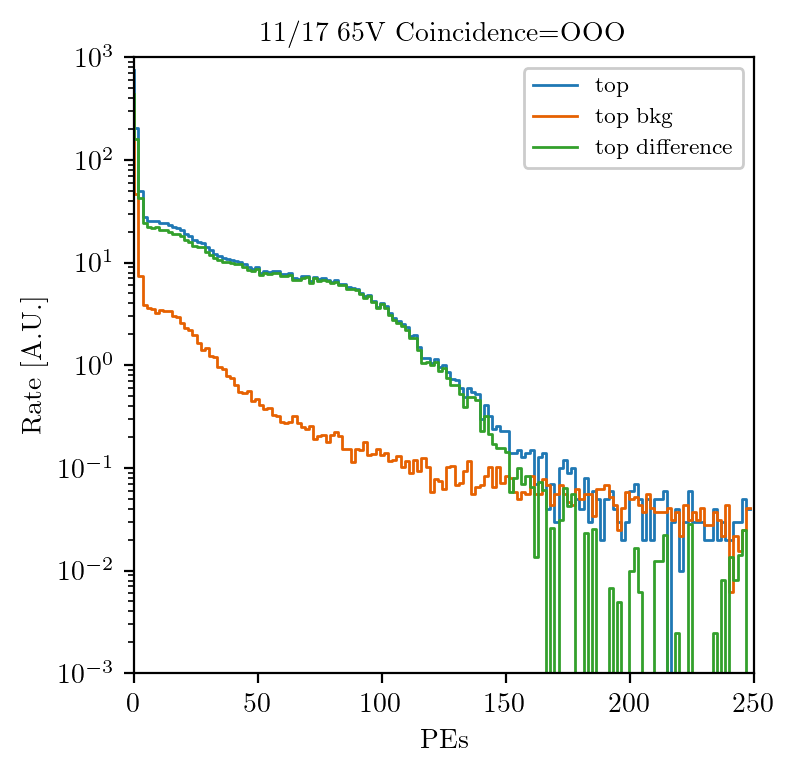

In [46]:
xmin = 0
xmax = 250
nbins = 150
bin_width = (xmax-xmin)/nbins

hist = [] #[top, top bkg, bot, bot bkg, top diff, bot diff]
hist_bins = []
hist_err = []
plt.figure(0,figsize=(4,4))
bkg_boundary = 200
for i,dset in enumerate(ds1117[:2]):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
    norm_factor = np.sum(h[int((bkg_boundary-xmin)/bin_width):])
    hist_err.append(np.sqrt(h)/norm_factor)
    h = h/norm_factor
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
plt.step(hist_bins[0][:-1], hist[0]-hist[1], label='top difference', linewidth=1)
hist_bins.append(hist_bins[0])
hist.append(hist[0]-hist[1])
hist_err.append(np.sqrt(hist[0]**2+hist[1]**2))
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 65V Coincidence=OOO')
plt.xlim(xmin, xmax)

0.18 0.5 10.911403352392078
0.1875 0.5 6.24875355099719
0.195 0.5 2.855256049808556
0.20249999999999999 0.5 1.201860743347813
0.21 0.5 3.8593485938681975
0.18 1.625 5.802867925018834
0.1875 1.625 2.480384871928733
0.195 1.625 0.47132256918383314
0.20249999999999999 1.625 1.5555307232768338
0.21 1.625 5.472533401669865
0.18 2.75 2.9399051671326117
0.1875 2.75 1.126790984085616
0.195 2.75 0.8138837899069034
0.20249999999999999 2.75 3.6184426646368184
0.21 2.75 9.739319338956141
0.18 3.875 1.3958472853178407
0.1875 3.875 0.9982365543870153
0.195 3.875 3.4640389765275006
0.20249999999999999 3.875 7.330117444234788
0.21 3.875 15.734898071690145
0.18 5.0 1.1644623824974027
0.1875 5.0 2.2416045391351167
0.195 5.0 5.236729079642822
0.20249999999999999 5.0 12.757655460783205
0.21 5.0 22.133321261908016


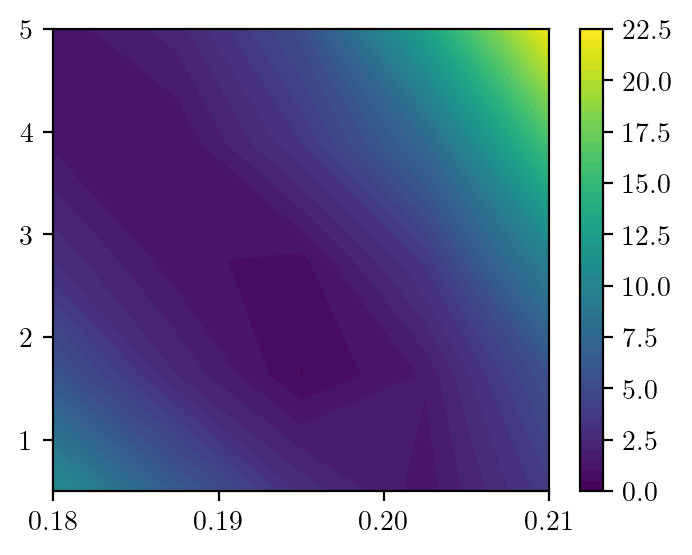

174324 events simulated


(0.01, 1000.0)

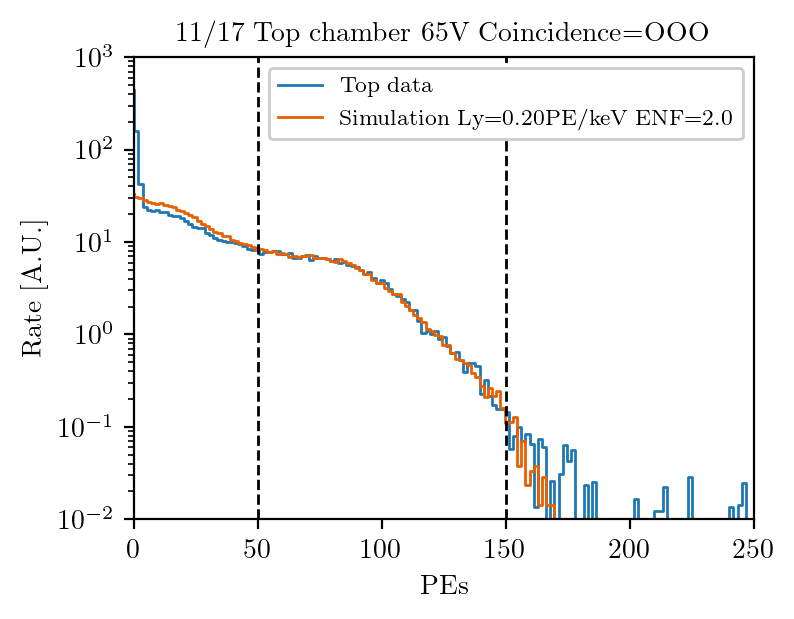

In [57]:
# TOP CHAMBER
file = ROOT.TFile("~/sipm-analysis/jupyter/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

lys = np.linspace(0.18, 0.21, 5)
enfs = np.linspace(0.5, 5, 5)
X,Y = np.meshgrid(lys, enfs)
fig,ax=plt.subplots(1,1)

norm_min = 50
norm_max = 150
cp=ax.contourf(X, Y, np.array([[chisquare_two_hist(ly_, enf_, hist[2], hist_bins[2], hist_err[2], tr, [norm_min,norm_max]) for ly_ in lys] for enf_ in enfs]), 50)
# cp=ax.contourf(X,Y,np.sqrt(X**2+Y**2))
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()

ly = 0.195
enf = 2.0
simPE = []
nev = 0
for i,ev in enumerate(tr):
    for j in range(1):
        simPE.append(normal(ly*tr.Edep, np.sqrt(enf*ly*tr.Edep)))
        nev += 1
print('{} events simulated'.format(nev))
file.Close()

ymin = 1e-2
ymax = 1e3
hSimTop, hSimTop_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins))
hSimTop = hSimTop*np.sum(hist[2][int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSimTop[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
plt.step(hist_bins[2][:-1], hist[2], label='Top data', linewidth=1)
plt.step(hSimTop_bins[:-1], hSimTop, label='Simulation Ly={:.2f}PE/keV ENF={:.1f}'.format(ly, enf), linewidth=1)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Top chamber 65V Coincidence=OOO')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

(0.0, 1200.0)

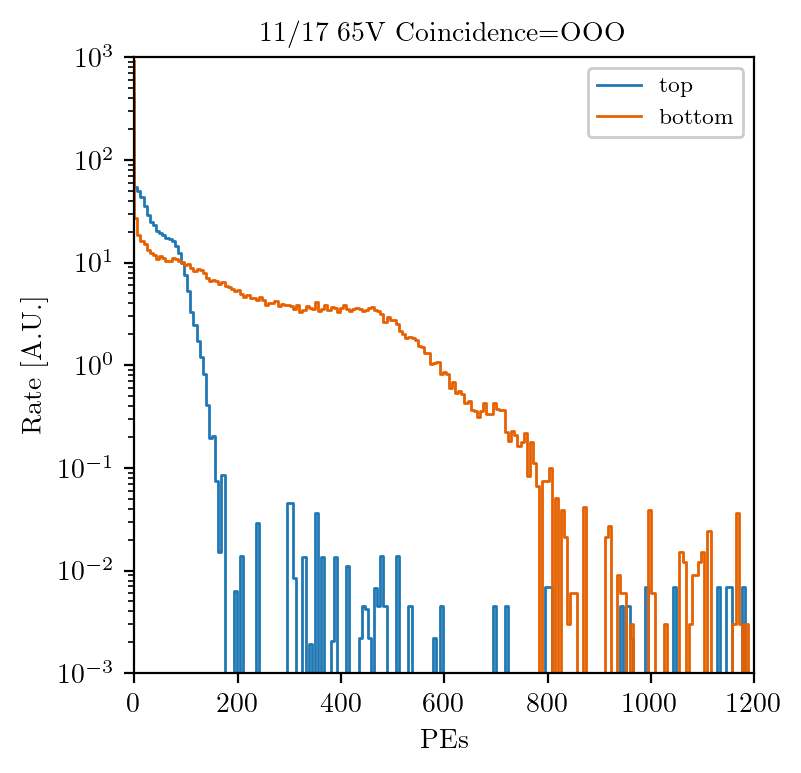

In [58]:
xmin = 0
xmax = 1200
nbins = 200
bin_width = (xmax-xmin)/nbins

hist = [] #[top, top bkg, bot, bot bkg, top diff, bot diff]
hist_bins = []
hist_err = []
plt.figure(0,figsize=(4,4))
bkg_boundary = [250, 250, 1000, 1000]
for i,dset in enumerate(ds1117):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
    norm_factor = np.sum(h[int((bkg_boundary[i]-xmin)/bin_width):])
    h = h/norm_factor
    hist.append(h)
    hist_bins.append(hx)
    hist_err.append(np.sqrt(h)/norm_factor)
#     plt.step(hx[:-1], h, label=labels[i], linewidth=1)
    
plt.step(hist_bins[0][:-1], hist[0]-hist[1], label='top', linewidth=1)
hist_bins.append(hist_bins[0])
hist.append(hist[0]-hist[1])
hist_err.append(np.sqrt(hist[0]**2 + hist[1]**2))
plt.step(hist_bins[2][:-1], hist[2]-hist[3], label='bottom', linewidth=1)
hist_bins.append(hist_bins[2])
hist.append(hist[2]-hist[3])
hist_err.append(np.sqrt(hist[2]**2 + hist[3]**2))
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 65V Coincidence=OOO')
plt.xlim(xmin, xmax)

1.0 1.0 11.783736907546993
1.025 1.0 8.871095179328595
1.05 1.0 5.669849783865379
1.0750000000000002 1.0 4.140740759832866
1.1 1.0 5.462134775147347
1.0 3.25 6.900884795415045
1.025 3.25 4.050148881917539
1.05 3.25 1.7417875485551826
1.0750000000000002 3.25 1.6044096645929873
1.1 3.25 5.035929679671822
1.0 5.5 4.836727026171609
1.025 5.5 2.4847008939495185
1.05 5.5 1.5666724466051172
1.0750000000000002 5.5 2.759708197705846
1.1 5.5 6.414283731687032
1.0 7.75 3.4935603729199367
1.025 7.75 2.4535577806640507
1.05 7.75 2.583763658852739
1.0750000000000002 7.75 5.104430624466381
1.1 7.75 9.032992921082258
1.0 10.0 3.0220189872421157
1.025 10.0 2.6252742123845607
1.05 10.0 3.4463504460054186
1.0750000000000002 10.0 5.806725245522044
1.1 10.0 9.798788902529045


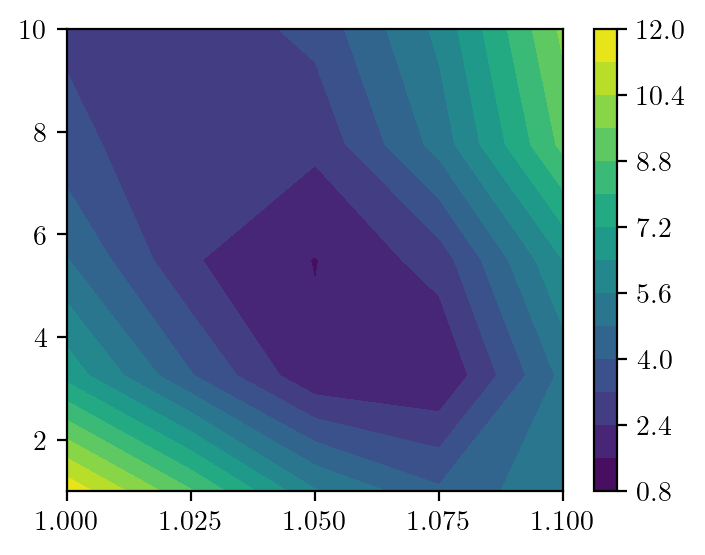

174324 events simulated


(0.01, 1000.0)

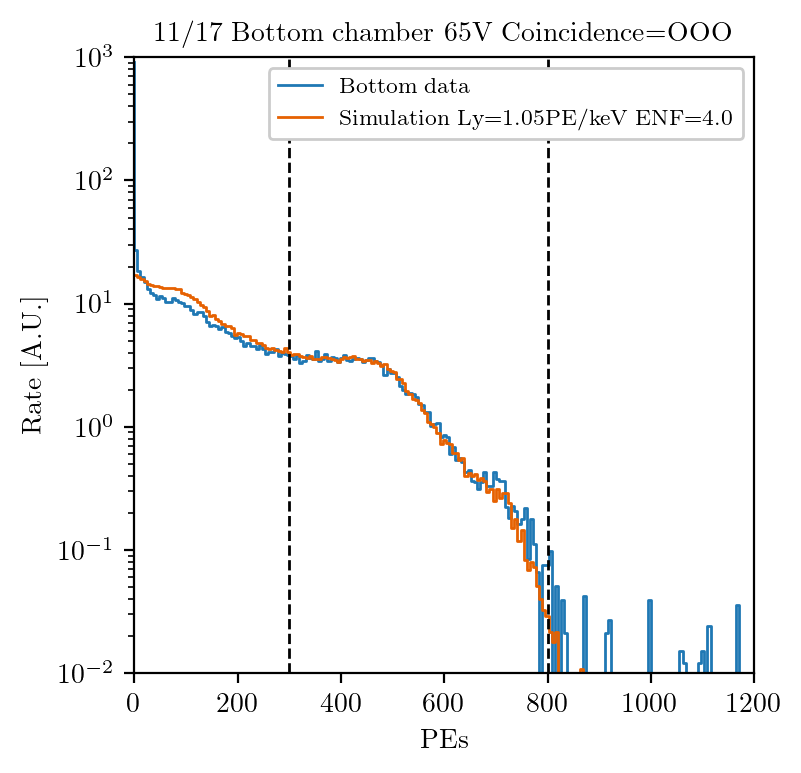

In [61]:
# BOTTOM CHAMBER
lys = np.linspace(1.00, 1.1, 5)
enfs = np.linspace(1, 10, 5)
X,Y = np.meshgrid(lys, enfs)
fig,ax=plt.subplots(1,1)
file = ROOT.TFile("~/sipm-analysis/jupyter/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

norm_min = 300
norm_max = 800
cp=ax.contourf(X, Y, np.array([[chisquare_two_hist(ly_, enf_, hist[5], hist_bins[5], hist_err[5], tr, [norm_min,norm_max]) for ly_ in lys] for enf_ in enfs]), 15)
# cp=ax.contourf(X,Y,np.sqrt(X**2+Y**2))
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()

# Plot spectrum
plt.figure(1,figsize=(4,4))
ly = 1.05
enf = 4.
simPE = []
nev = 0
for i,ev in enumerate(tr):
    for j in range(1):
        simPE.append(normal(ly*tr.Edep, np.sqrt(enf*ly*tr.Edep)))
        nev += 1
print('{} events simulated'.format(nev))

ymin = 1e-2
ymax = 1e3
hSimBot, hSimBot_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins))
hSimBot = hSimBot*np.sum(hist[5][int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSimBot[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
plt.step(hist_bins[5][:-1], hist[5], label='Bottom data', linewidth=1)
plt.step(hSimBot_bins[:-1], hSimBot, label='Simulation Ly={:.2f}PE/keV ENF={:.1f}'.format(ly, enf), linewidth=1)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Bottom chamber 65V Coincidence=OOO')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Test different bias voltage

In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
bias = [63, 65, 67, 69, 71]

In [7]:
ds1120top = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            # dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.summed_integral_pe.append(ev.sum_pe)
            dset.fprompt.append(ev.f_prompt)
            nev_cut += 1
            
    print('Top {}V {} events loaded'.format(v, nev))
    print('Cut fraction = {:.3f}%'.format(100*(1-nev_cut/nev)))
    ds1120top.append(dset)
    
ds1118top_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            # dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.summed_integral_pe.append(ev.sum_pe)
            dset.fprompt.append(ev.f_prompt)
            nev_cut += 1

    print('Top {}V {} events loaded'.format(v, nev))
    print('Cut fraction = {:.3f}%'.format(100*(1-nev_cut/nev)))
    ds1118top_bkg.append(dset)

Top 63V 1003373 events loaded
Cut fraction = 0.538%
Top 65V 1007528 events loaded
Cut fraction = 0.539%
Top 67V 1016980 events loaded
Cut fraction = 0.601%
Top 69V 1014919 events loaded
Cut fraction = 0.667%
Top 71V 1015092 events loaded
Cut fraction = 0.737%
Top 63V 217218 events loaded
Cut fraction = 0.119%
Top 65V 217008 events loaded
Cut fraction = 0.066%
Top 67V 218302 events loaded
Cut fraction = 0.061%
Top 69V 217576 events loaded
Cut fraction = 0.080%
Top 71V 216743 events loaded
Cut fraction = 0.076%


## Quality cuts
## Baseline noise

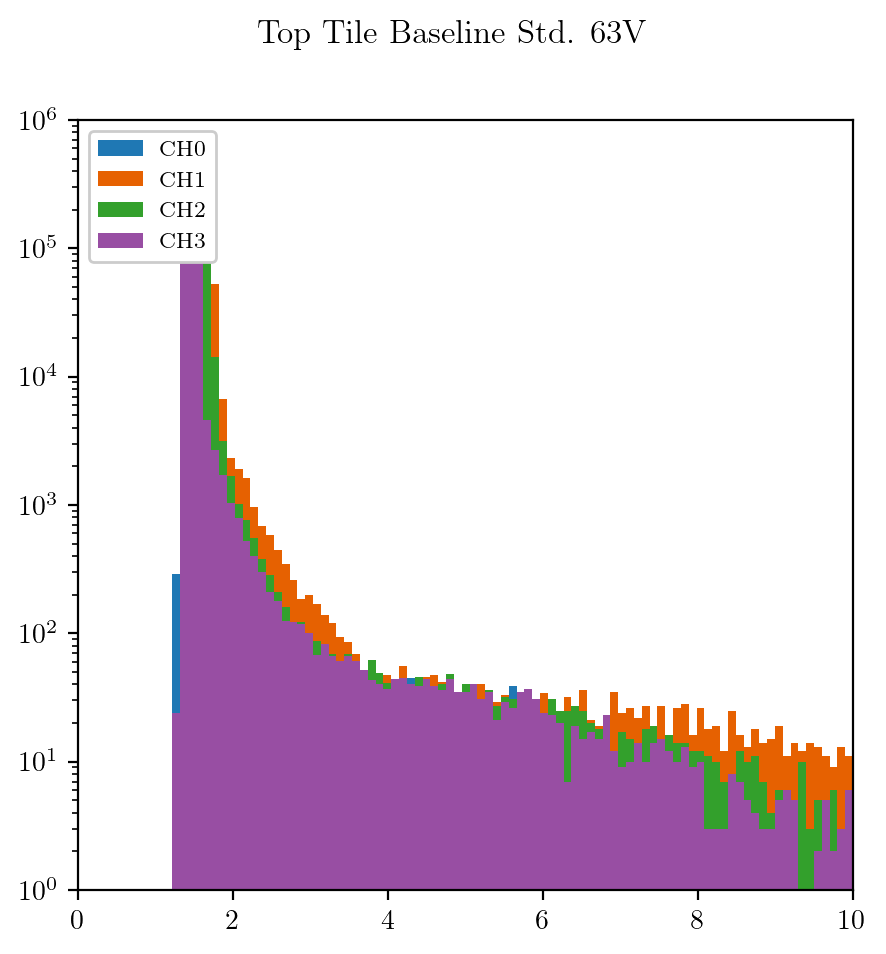

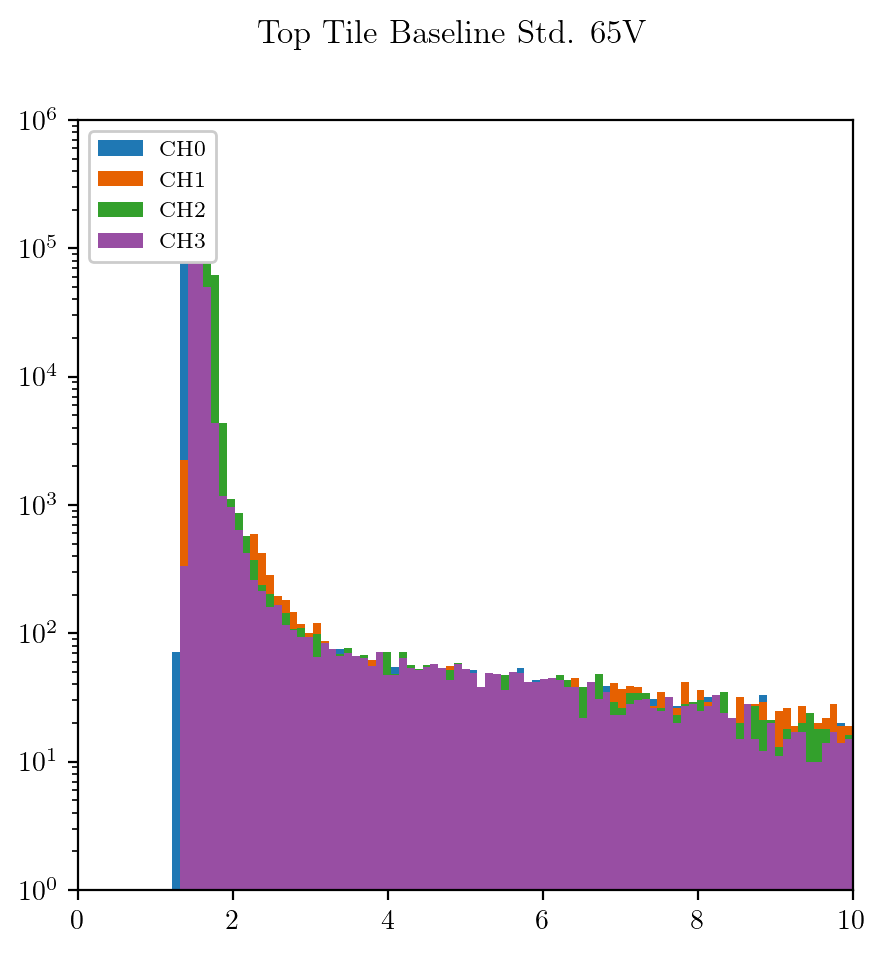

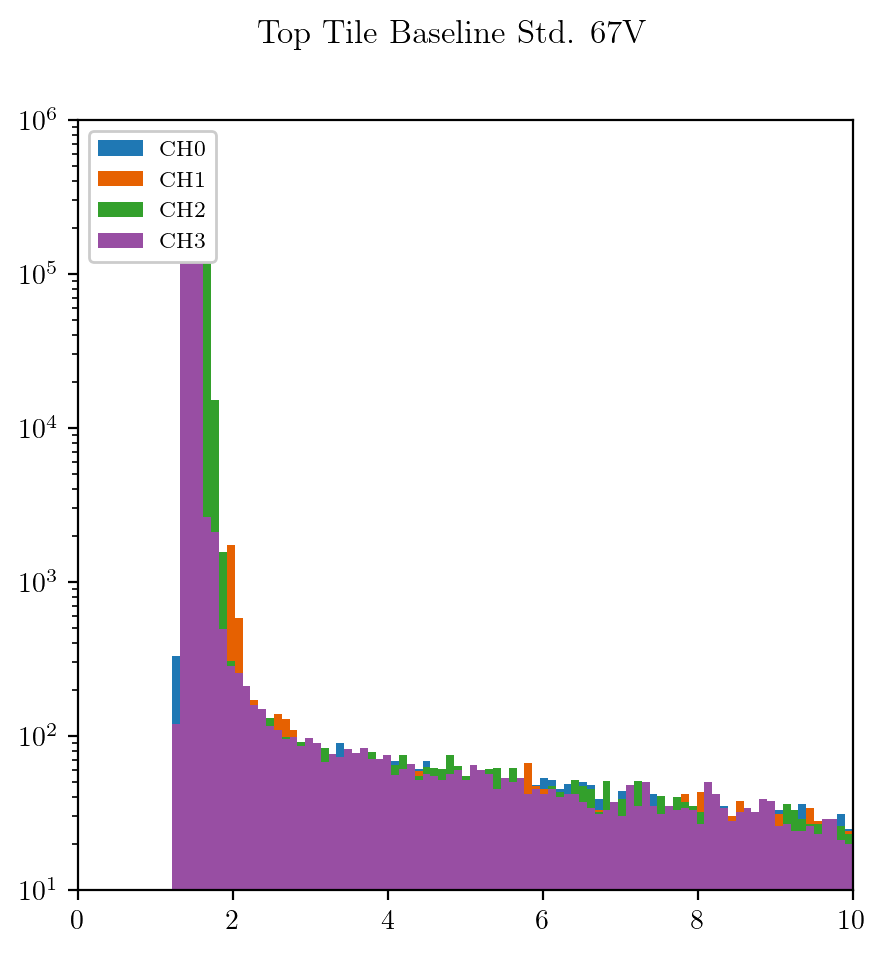

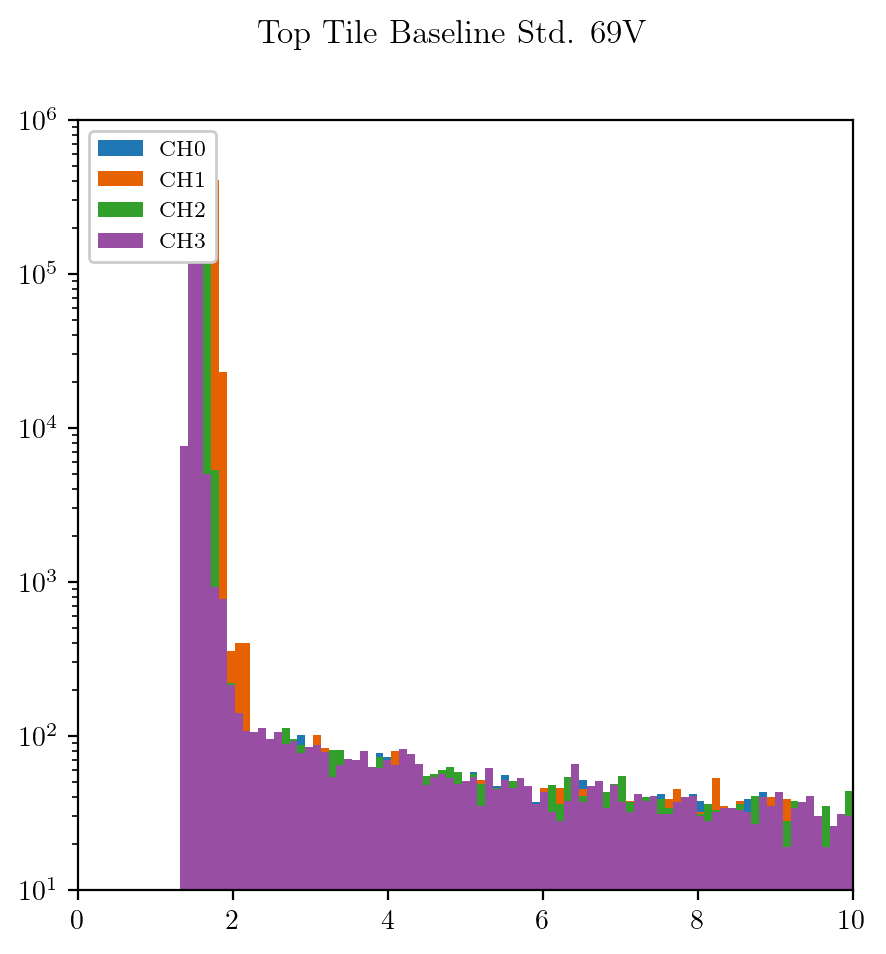

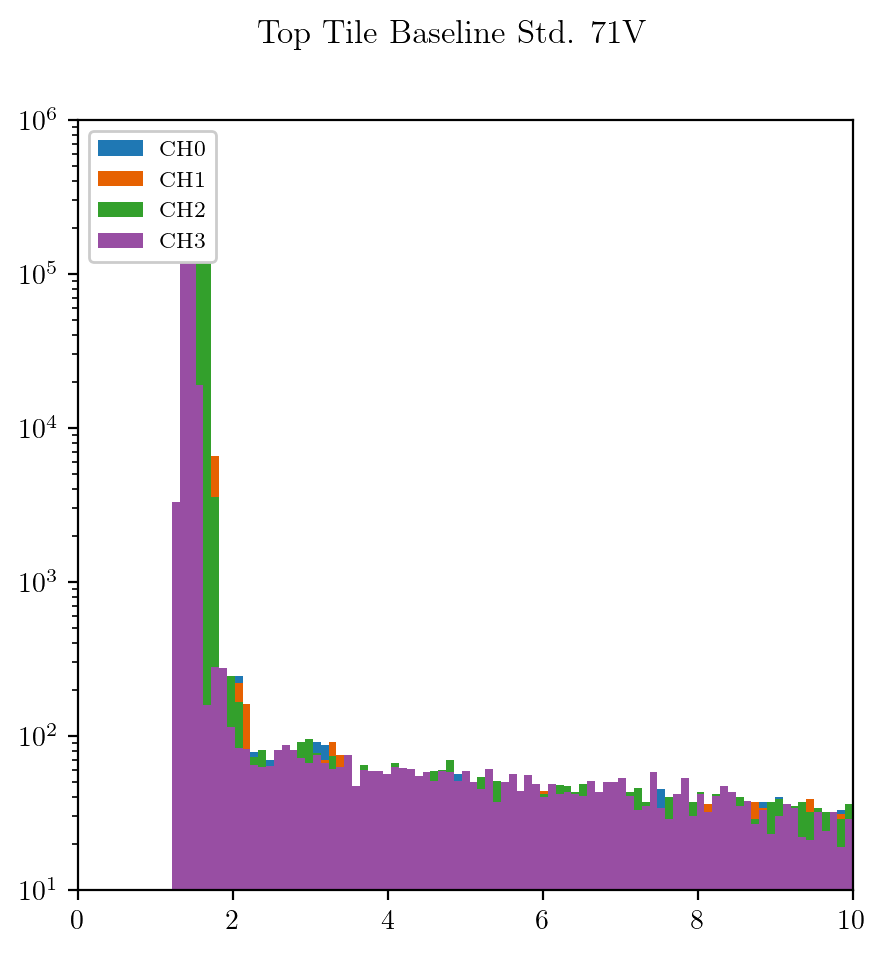

In [16]:
for i,v in enumerate(bias):
    plt.figure(i,figsize=(5,5))
    for ch in range(4):
        plt.hist(ds1120top[i].ch[ch].baseline_std, bins=np.linspace(0, 10, 100), label='CH{}'.format(ch))
    plt.yscale('log')
    plt.legend()
    plt.suptitle('Top Tile Baseline Std. {}V'.format(v))

(0.0, 250.0)

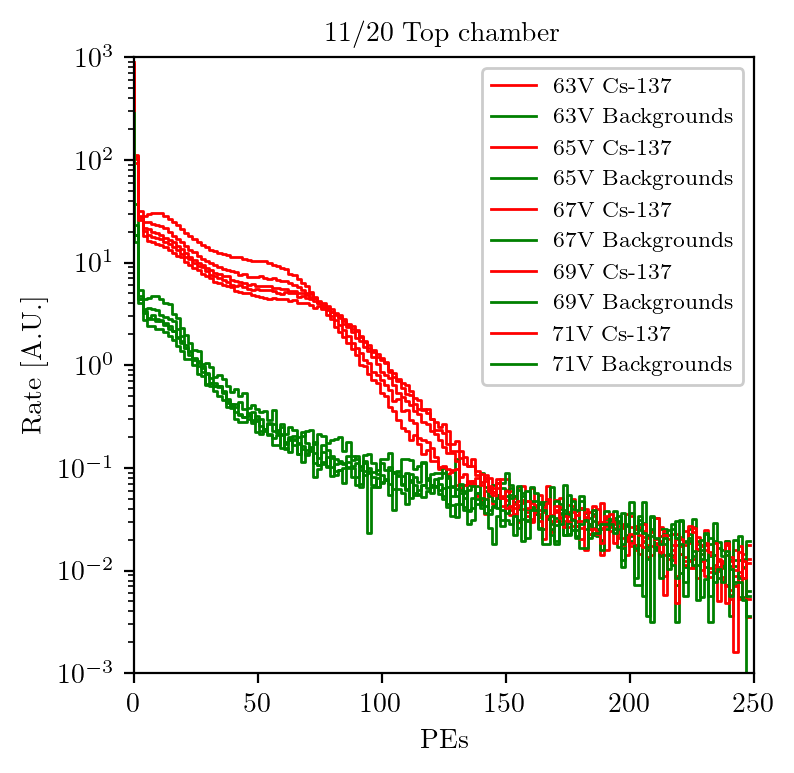

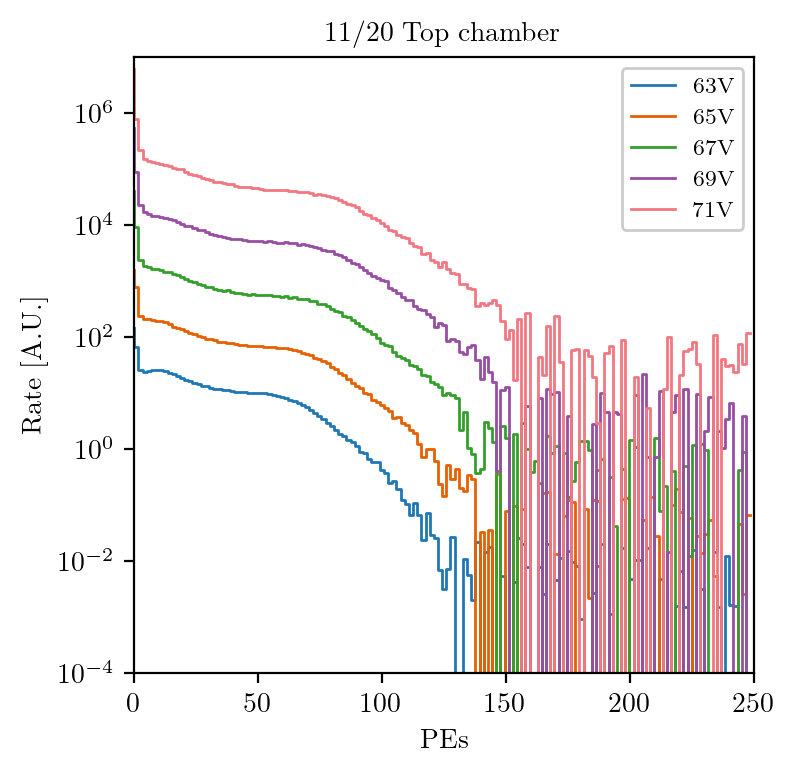

In [13]:
xmin = 0
xmax = 250
nbins = 150
bin_width = (xmax-xmin)/nbins

hist_gamma = []
hist_gamma_bins = []
hist_bkg = []
hist_bkg_bins = []
hist_dif = []
hist_dif_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [170, 170, 170, 170, 170]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120top)):
    hg,hgx = np.histogram(ds1120top[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    hg = hg/np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_gamma.append(hg)
    hist_gamma_bins.append(hgx)
    plt.step(hgx[:-1], hg, '{}'.format(color[0]), label='{}V {}'.format(bias[i], source[0]), linewidth=1)

    hb,hbx = np.histogram(ds1118top_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    hb = hb/np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_bkg.append(hb)
    hist_bkg_bins.append(hbx)
    plt.step(hbx[:-1], hb, '{}'.format(color[1]), label='{}V {}'.format(bias[i], source[1]), linewidth=1)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)


plt.figure(1,figsize=(4,4))
hist_dif_bins = hist_gamma_bins
for i in range(len(hist_gamma)):
    hist_dif.append(hist_gamma[i]-hist_bkg[i])
    plt.step(hist_dif_bins[i][:-1], hist_dif[i]*10**i, label='{}V'.format(bias[i]), linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)

In [15]:
ds1120bot = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            # dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.summed_integral_pe.append(ev.sum_pe)
            dset.fprompt.append(ev.f_prompt)
            nev_cut += 1
            
    print('Bottom {}V {} events loaded'.format(v, nev))
    print('Cut fraction = {:.3f}%'.format(100*(1-nev_cut/nev)))
    ds1120bot.append(dset)
    
ds1118bot_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            # dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.summed_integral_pe.append(ev.sum_pe)
            dset.fprompt.append(ev.f_prompt)
            nev_cut += 1
            
    print('Bottom {}V {} events loaded'.format(v, nev))
    print('Cut fraction = {:.3f}%'.format(100*(1-nev_cut/nev)))
    ds1118bot_bkg.append(dset)

Bottom 63V 1014166 events loaded
Cut fraction = 0.606%
Bottom 65V 1015363 events loaded
Cut fraction = 0.774%
Bottom 67V 1015290 events loaded
Cut fraction = 0.984%
Bottom 69V 1014591 events loaded
Cut fraction = 1.255%
Bottom 71V 1015157 events loaded
Cut fraction = 1.412%
Bottom 63V 216580 events loaded
Cut fraction = 0.072%
Bottom 65V 216617 events loaded
Cut fraction = 0.091%
Bottom 67V 217771 events loaded
Cut fraction = 0.112%
Bottom 69V 217350 events loaded
Cut fraction = 0.140%
Bottom 71V 218261 events loaded
Cut fraction = 0.173%


(0.0, 1200.0)

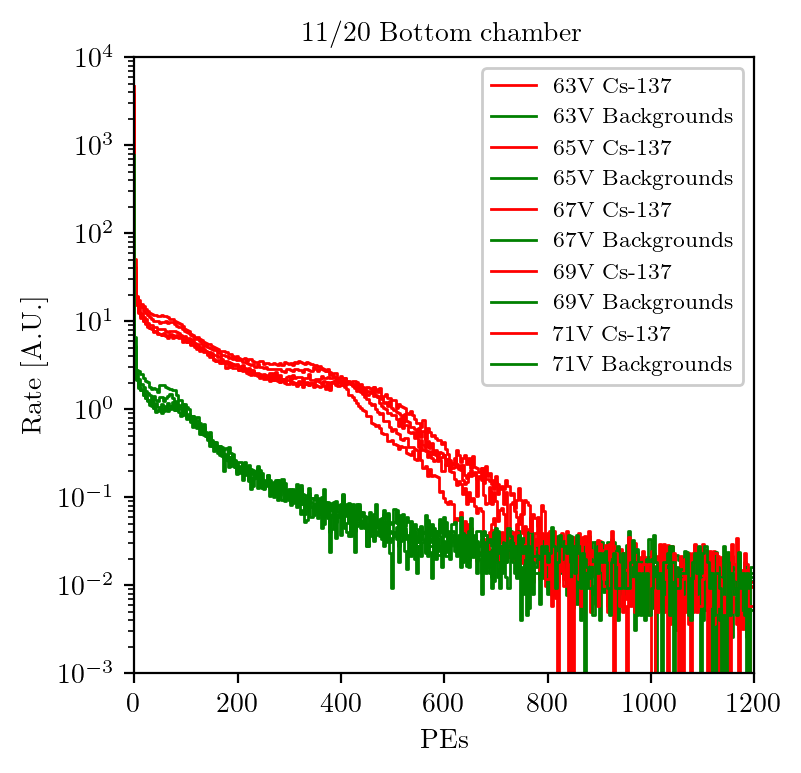

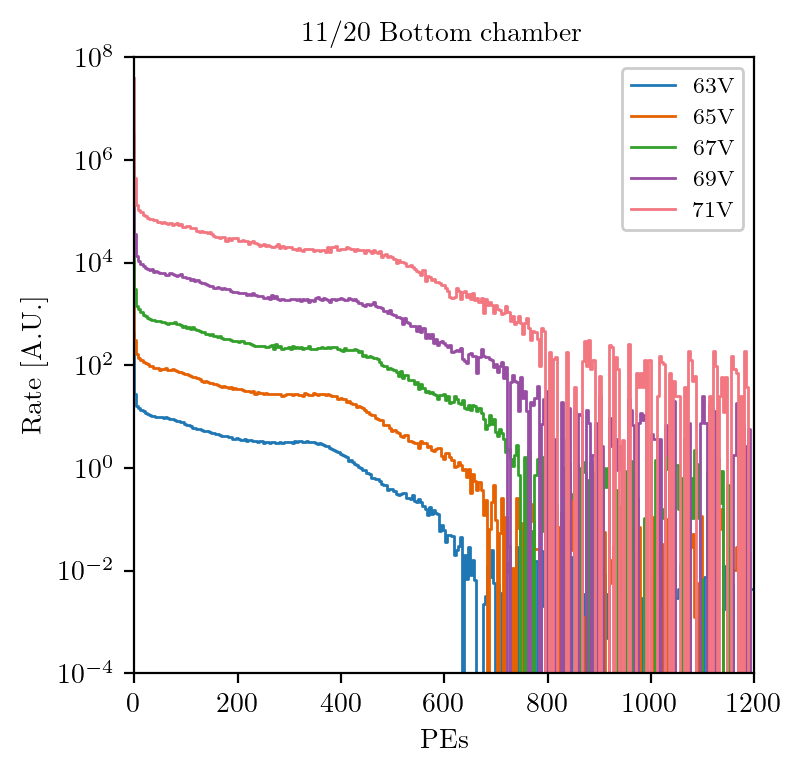

In [17]:
xmin = 0
xmax = 1200
nbins = 300
bin_width = (xmax-xmin)/nbins

hist_gamma = []
hist_gamma_bins = []
hist_bkg = []
hist_bkg_bins = []
hist_dif = []
hist_dif_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [900, 900, 900, 900, 900]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120bot)):
    hg,hgx = np.histogram(ds1120bot[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    hg = hg/np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_gamma.append(hg)
    hist_gamma_bins.append(hgx)
    plt.step(hgx[:-1], hg, '{}'.format(color[0]), label='{}V {}'.format(bias[i], source[0]), linewidth=1)

    hb,hbx = np.histogram(ds1118bot_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    hb = hb/np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_bkg.append(hb)
    hist_bkg_bins.append(hbx)
    plt.step(hbx[:-1], hb, '{}'.format(color[1]), label='{}V {}'.format(bias[i], source[1]), linewidth=1)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)


plt.figure(1,figsize=(4,4))
hist_dif_bins = hist_gamma_bins
for i in range(len(hist_gamma)):
    hist_dif.append(hist_gamma[i]-hist_bkg[i])
    plt.step(hist_dif_bins[i][:-1], hist_dif[i]*10**i, label='{}V'.format(bias[i]), linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)